<a href="https://colab.research.google.com/github/teraz1112/MNIST/blob/main/%E7%A0%94%E4%BF%AE%E2%85%A0mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# グラフのスタイルを指定
plt.style.use('seaborn-darkgrid')

<ipython-input-1-b5102bfc1efc>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [ ]:
tensor = torch.Tensor([1, 2, 3])
tensor

tensor([1., 2., 3.])

In [ ]:
def fix_seed(seed=0):
    # numpy
    np.random.seed(seed)
    # pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

fix_seed()

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=False,
                                           transform=transforms.ToTensor(),
                                           download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 103490388.55it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 10368543.51it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30685334.60it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1089473.22it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
fig, label = train_dataset[0]
print(f'fig shape : {fig.size()}, label : {label}')

fig shape : torch.Size([1, 28, 28]), label : 5


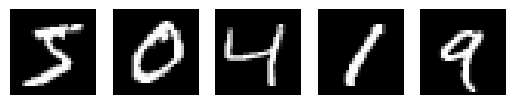

In [ ]:
fig, axes = plt.subplots(1, 5)
for i in range(5):
    axes[i].imshow(train_dataset[i][0].view(-1, 28), cmap='gray')
    axes[i].axis("off")

In [ ]:
batch_size = 256


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)


In [ ]:
num_classes = 10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net().to(device)

In [ ]:
print(model)


Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
         [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
         [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
         ...,
         [-0.0278,  0.0100, -0.0151,  ...,  0.0356,  0.0340, -0.0310],
         [ 0.0174,  0.0051,  0.0038,  ...,  0.0176,  0.0174, -0.0338],
         [-0.0280, -0.0009,  0.0183,  ...,  0.0242, -0.0098,  0.0033]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0333,  0.0170, -0.0219,  ...,  0.0060,  0.0348, -0.0311],
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.0253, -0.0153, -0.0038,  ...,  0.0303,  0.0296, -0.0242],
         [ 0.0153,  0.0083,  0.0182,  ...,  0.0184, -0.0009,  0.0101],
         [ 0.0035, -0.0090, -0.0304,  ..., -0.0211, -0.0054, -0.0092],
         ...,
         [-0.0223,  0.0174, -0.0287,  ..., -0.0040, -0.0202,  0.0009],
         [ 0.0201,  0.0113,  0.0016,  ...,  0.0105, -0.0081,  0.

In [ ]:
# 順伝搬の確認
input_samples = torch.randn(5, 784, device=device)
output_samples = model(input_samples)
print(output_samples.size())


torch.Size([5, 10])


In [ ]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# 最適化手法を設定
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
def train_fn(model, train_loader, criterion, optimizer, device='cpu'):

    # 1epoch training
    train_loss = 0.0
    num_train = 0

    # model 学習モードに設定
    model.train()

    for i, (images, labels) in enumerate(train_loader):
        # batch数を累積
        num_train += len(labels)

        # viewで1次元配列に変更
        # toでgpuに転送
        images, labels = images.view(-1, 28*28).to(device), labels.to(device)
        # 勾配をリセット
        optimizer.zero_grad()
        # 推論
        outputs = model(images)
        # lossを計算
        loss = criterion(outputs, labels)
        # 誤差逆伝播
        loss.backward()
        # パラメータ更新
        optimizer.step()
        # lossを累積
        train_loss += loss.item()

    train_loss = train_loss/num_train

    return train_loss

In [ ]:
def valid_fn(model, train_loader, criterion, optimizer, device='cpu'):

    # 評価用のコード
    valid_loss = 0.0
    num_valid = 0

    # model 評価モードに設定
    model.eval()

    # 評価の際に勾配を計算しないようにする
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            num_valid += len(labels)
            images, labels = images.view(-1, 28*28).to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

        valid_loss = valid_loss/num_valid

    return valid_loss

In [ ]:
def run(model, train_loader, test_loader, criterion, optimizer, device='cpu'):

    train_loss_list = []
    valid_loss_list = []

    for epoch in range(num_epochs):

        _train_loss = train_fn(model, train_loader, criterion, optimizer, device=device)
        _valid_loss = valid_fn(model, train_loader, criterion, optimizer, device=device)

        print(f'Epoch [{epoch+1}], train_Loss : {_train_loss:.5f}, val_Loss : {_valid_loss:.5f}')

        train_loss_list.append(_train_loss)
        valid_loss_list.append(_valid_loss)

    return train_loss_list, valid_loss_list

In [ ]:
num_epochs = 20
train_loss_list, test_loss_list = run(model, train_loader, test_loader, criterion, optimizer, device=device)


Epoch [1], train_Loss : 0.00872, val_Loss : 0.00844
Epoch [2], train_Loss : 0.00728, val_Loss : 0.00592
Epoch [3], train_Loss : 0.00450, val_Loss : 0.00342
Epoch [4], train_Loss : 0.00291, val_Loss : 0.00247
Epoch [5], train_Loss : 0.00227, val_Loss : 0.00203
Epoch [6], train_Loss : 0.00194, val_Loss : 0.00178
Epoch [7], train_Loss : 0.00174, val_Loss : 0.00162
Epoch [8], train_Loss : 0.00161, val_Loss : 0.00151
Epoch [9], train_Loss : 0.00151, val_Loss : 0.00142
Epoch [10], train_Loss : 0.00144, val_Loss : 0.00137
Epoch [11], train_Loss : 0.00138, val_Loss : 0.00131
Epoch [12], train_Loss : 0.00133, val_Loss : 0.00127
Epoch [13], train_Loss : 0.00129, val_Loss : 0.00123
Epoch [14], train_Loss : 0.00126, val_Loss : 0.00120
Epoch [15], train_Loss : 0.00122, val_Loss : 0.00117
Epoch [16], train_Loss : 0.00119, val_Loss : 0.00114
Epoch [17], train_Loss : 0.00117, val_Loss : 0.00113
Epoch [18], train_Loss : 0.00114, val_Loss : 0.00110
Epoch [19], train_Loss : 0.00112, val_Loss : 0.00108
Ep

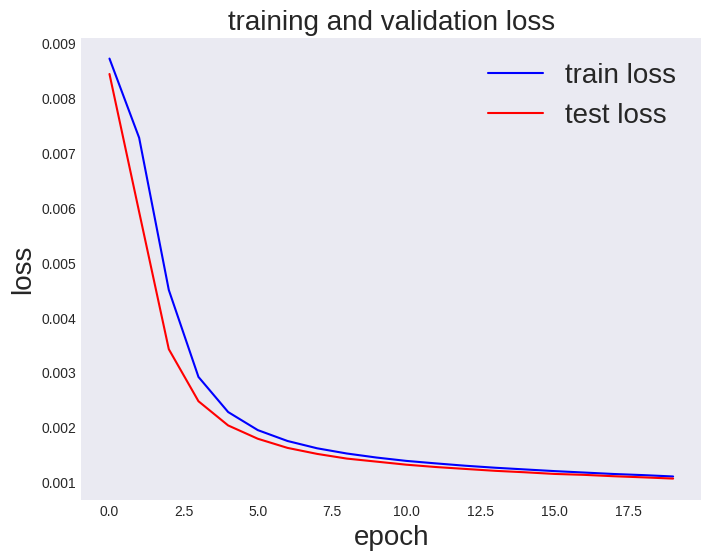

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(range(len(train_loss_list)), train_loss_list, c='b', label='train loss')
ax.plot(range(len(test_loss_list)), test_loss_list, c='r', label='test loss')

ax.set_xlabel('epoch', fontsize='20')
ax.set_ylabel('loss', fontsize='20')
ax.set_title('training and validation loss', fontsize='20')
ax.grid()
ax.legend(fontsize='20')

plt.show()

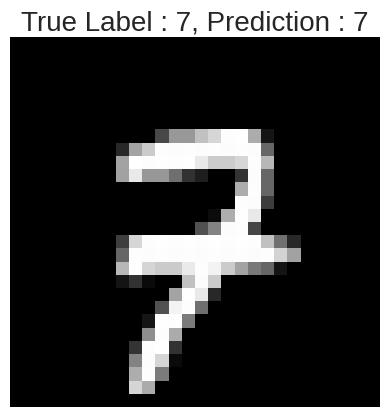

In [ ]:
# datasetからサンプルを一つ取り出す
image, label = test_dataset[144]
image = image.view(-1, 28*28).to(device)

# 推論
prediction_label = torch.argmax(model(image))

fig, ax = plt.subplots()
ax.imshow(image.detach().to('cpu').numpy().reshape(28, 28), cmap='gray')

ax.axis('off')
ax.set_title(f'True Label : {label}, Prediction : {prediction_label}', fontsize=20)

plt.show()
